LSSVR

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import multiprocessing as mp
from itertools import product
from lssvr import LSSVR

def lssvr_update_progress_bar(completed, total, bar_length=50):
    progress = int(bar_length * completed / total)
    bar = '#' * progress + '_' * (bar_length - progress)
    print(f'[{bar}] {completed}/{total} iterations completed', end='\r')

def lssvr_process_lssvr_combination(args):
    lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature, lssvr_X, lssvr_y, lssvr_num_splits = args
    lssvr_kf = KFold(n_splits=lssvr_num_splits, shuffle=True, random_state=lssvr_run)
    lssvr_rmses = []

    for lssvr_train_index, lssvr_test_index in lssvr_kf.split(lssvr_X):
        lssvr_X_train, lssvr_X_test = lssvr_X.iloc[lssvr_train_index], lssvr_X.iloc[lssvr_test_index]
        lssvr_y_train, lssvr_y_test = lssvr_y.iloc[lssvr_train_index], lssvr_y.iloc[lssvr_test_index]

        # Standardize features
        lssvr_scaler = StandardScaler()
        lssvr_X_train_scaled = lssvr_scaler.fit_transform(lssvr_X_train)
        lssvr_X_test_scaled = lssvr_scaler.transform(lssvr_X_test)

        # Ensure lssvr_y_train is a numpy array for proper indexing
        lssvr_y_train = lssvr_y_train.values

        lssvr_model = LSSVR(kernel='rbf', gamma=lssvr_gamma, C=lssvr_C)
        lssvr_model.fit(lssvr_X_train_scaled, lssvr_y_train)

        lssvr_predictions = lssvr_model.predict(lssvr_X_test_scaled)
        lssvr_rmse = 100 * sqrt(mean_squared_error(lssvr_y_test, lssvr_predictions)) / np.sqrt(np.mean(np.square(lssvr_y_test)))
        lssvr_rmses.append(lssvr_rmse)

    return np.mean(lssvr_rmses)

if __name__ == '__main__':
    print("Loading data...")
    lssvr_train_df = pd.read_csv('./../Data/complete_data.csv')
    print("Data is loaded in, now running the model:")

    lssvr_sexes = ['All', 'Male', 'Female']
    lssvr_target_features = ["ALM", "% fat - Total", "BMD - Total"]

    lssvr_gammas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
    # ^ gamma controls the influence of individual training samples(low valures are 'far' while high values are 'close')
    lssvr_Cs = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000, 10000]
    # ^ C regulization parameter controls the trade-off between achieving a low training error and a low testing error
    lssvr_num_runs = 10  # Increased for more robust results
    lssvr_num_splits = 5

    lssvr_excluded_columns = ["PPT ID", "Site", "Gender", "Race", "BMD - Total", "ALM", "% fat - Total"]

    lssvr_results_tensor = np.zeros((len(lssvr_sexes), len(lssvr_gammas), len(lssvr_Cs), len(lssvr_target_features)))

    lssvr_combinations = list(product(lssvr_sexes, lssvr_gammas, lssvr_Cs, range(lssvr_num_runs), lssvr_target_features))
    lssvr_total_iterations = len(lssvr_combinations)

    with mp.Pool(processes=mp.cpu_count()) as lssvr_pool:
        lssvr_results = []
        for lssvr_i, (lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature) in enumerate(lssvr_combinations):
            lssvr_filtered_df = lssvr_train_df if lssvr_sex == 'All' else lssvr_train_df[lssvr_train_df['Gender'] == lssvr_sex]
            lssvr_X = lssvr_filtered_df.drop(columns=lssvr_excluded_columns)
            lssvr_y = lssvr_filtered_df[lssvr_target_feature]
            
            lssvr_result = lssvr_pool.apply_async(lssvr_process_lssvr_combination, 
                                                  ((lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature, lssvr_X, lssvr_y, lssvr_num_splits),))
            lssvr_results.append((lssvr_sex, lssvr_gamma, lssvr_C, lssvr_target_feature, lssvr_result))
            
            lssvr_update_progress_bar(lssvr_i + 1, lssvr_total_iterations)

        for lssvr_sex, lssvr_gamma, lssvr_C, lssvr_target_feature, lssvr_result in lssvr_results:
            lssvr_sex_idx = lssvr_sexes.index(lssvr_sex)
            lssvr_gamma_idx = lssvr_gammas.index(lssvr_gamma)
            lssvr_C_idx = lssvr_Cs.index(lssvr_C)
            lssvr_target_feature_idx = lssvr_target_features.index(lssvr_target_feature)
            lssvr_results_tensor[lssvr_sex_idx, lssvr_gamma_idx, lssvr_C_idx, lssvr_target_feature_idx] += lssvr_result.get() / lssvr_num_runs

    print('\nAll iterations completed.')

Loading data...
Data is loaded in, now running the model:
[##################################################] 6480/6480 iterations completed
All iterations completed.


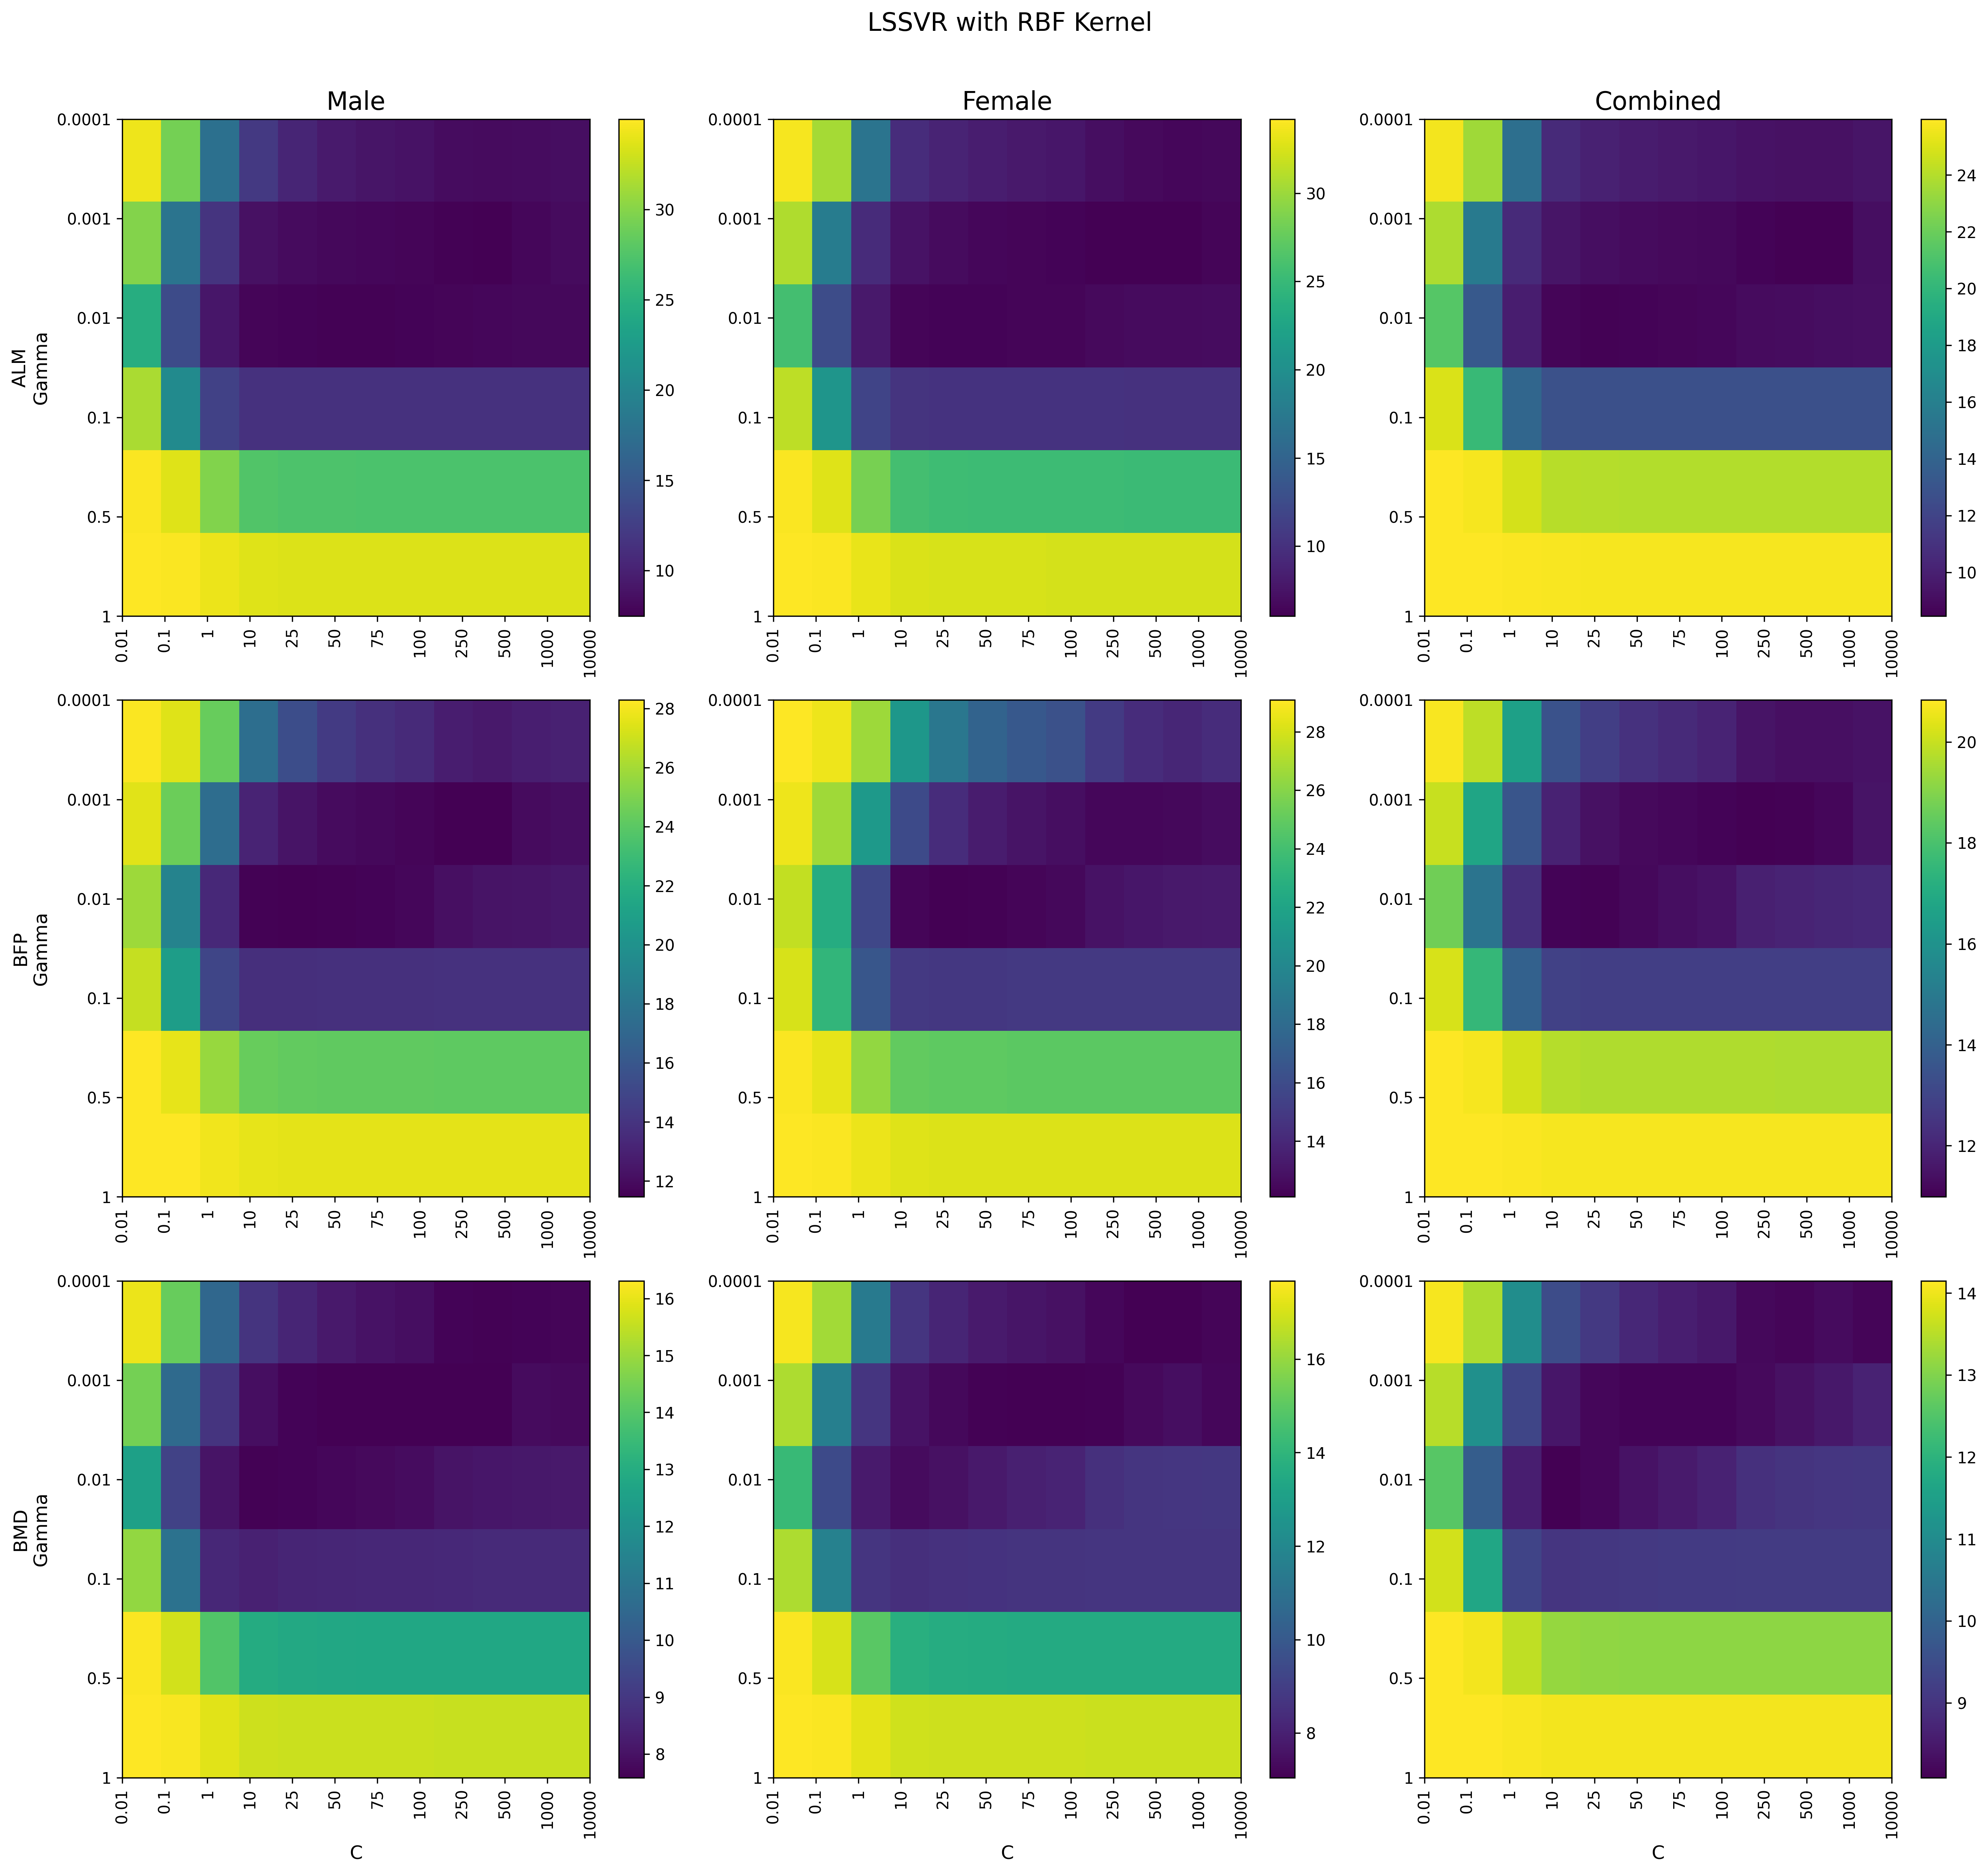

Best parameters for ALM (Male):
  Gamma: 0.001
  C: 500
  RMSE: 7.4697

Best parameters for ALM (Female):
  Gamma: 0.001
  C: 1000
  RMSE: 6.0332

Best parameters for ALM (All):
  Gamma: 0.001
  C: 1000
  RMSE: 8.4602

Best parameters for % fat - Total (Male):
  Gamma: 0.01
  C: 25
  RMSE: 11.4655

Best parameters for % fat - Total (Female):
  Gamma: 0.01
  C: 25
  RMSE: 12.0940

Best parameters for % fat - Total (All):
  Gamma: 0.001
  C: 250
  RMSE: 10.9861

Best parameters for BMD - Total (Male):
  Gamma: 0.001
  C: 250
  RMSE: 7.5873

Best parameters for BMD - Total (Female):
  Gamma: 0.001
  C: 100
  RMSE: 7.0485

Best parameters for BMD - Total (All):
  Gamma: 0.01
  C: 10
  RMSE: 8.0894



In [11]:
# Plotting the heatmaps
import matplotlib.pyplot as plt
import numpy as np

# Ensure these match the order in your results tensor
lssvr_target_features = ["ALM", "% fat - Total", "BMD - Total"]
lssvr_sexes = ['Male', 'Female', 'All']
lssvr_column_titles = ['Male', 'Female', 'Combined']  # Display titles as Male, Female, Combined
lssvr_row_titles = ['ALM', 'BFP', 'BMD']  # Order matches lssvr_target_features

# Create a figure to hold all subplots with specified DPI
fig, axes = plt.subplots(3, 3, figsize=(18, 18), dpi=300)

for i, lssvr_target in enumerate(lssvr_target_features):
    for j, lssvr_sex in enumerate(lssvr_sexes):
        ax = axes[i, j]
        
        # Extract the RMSE matrix for the current target and sex
        lssvr_rmse_matrix = lssvr_results_tensor[lssvr_sexes.index(lssvr_sex), :, :, i]
        
        # Plot the heatmap with correct orientation
        cax = ax.imshow(lssvr_rmse_matrix, cmap='viridis', aspect='auto', origin='upper',
                        extent=[0, len(lssvr_Cs)-1, 0, len(lssvr_gammas)-1])
        
        # Set x-axis tick labels
        ax.set_xticks(range(len(lssvr_Cs)))
        ax.set_xticklabels(lssvr_Cs, rotation=90)
        
        # Set y-axis tick labels
        ax.set_yticks(range(len(lssvr_gammas)))
        ax.set_yticklabels(lssvr_gammas[::-1])  # Reverse the order
        
        # Set labels and titles
        if i == 2:
            ax.set_xlabel('C', fontsize=12)
        if j == 0:
            ax.set_ylabel(f'{lssvr_row_titles[i]}\nGamma', fontsize=12)
        if i == 0:
            ax.set_title(lssvr_column_titles[j], fontsize=16)
        
        # Add colorbar
        fig.colorbar(cax, ax=ax)

plt.suptitle('LSSVR with RBF Kernel', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

# Find and print the best parameters
for lssvr_target_feature_idx, lssvr_target_feature in enumerate(lssvr_target_features):
    for lssvr_sex_idx, lssvr_sex in enumerate(lssvr_sexes):
        lssvr_best_idx = np.unravel_index(np.argmin(lssvr_results_tensor[lssvr_sex_idx, :, :, lssvr_target_feature_idx]),
                                          lssvr_results_tensor[lssvr_sex_idx, :, :, lssvr_target_feature_idx].shape)
        lssvr_best_gamma = lssvr_gammas[lssvr_best_idx[0]]
        lssvr_best_C = lssvr_Cs[lssvr_best_idx[1]]
        lssvr_best_rmse = lssvr_results_tensor[lssvr_sex_idx, lssvr_best_idx[0], lssvr_best_idx[1], lssvr_target_feature_idx]
        print(f"Best parameters for {lssvr_target_feature} ({lssvr_sex}):")
        print(f"  Gamma: {lssvr_best_gamma}")
        print(f"  C: {lssvr_best_C}")
        print(f"  RMSE: {lssvr_best_rmse:.4f}")
        print()
